In [1]:
import numpy as np
from numba import vectorize
import matplotlib.pyplot as plt
import torch
plt.style.use(['science','notebook'])

from pydftlj.dft3d import dft3d

# Author: Elvis do A. Soares
# Github: @elvissoares
# Date: 2023-05-29

/home/elvis/.local/lib/python3.10/site-packages/torch/cuda/__init__.py:107: UserWarning: CUDA initialization: The NVIDIA driver on your system is too old (found version 9010). Please update your GPU driver by downloading and installing a new version from the URL: http://www.nvidia.com/Download/index.aspx Alternatively, go to: https://pytorch.org to install a PyTorch version that has been compiled with your version of the CUDA driver. (Triggered internally at ../c10/cuda/CUDAFunctions.cpp:109.)
  return torch._C._cuda_getDeviceCount() > 0


In [2]:
@vectorize
def ljpotential(r,eps,sigma):
    return 4*eps*((sigma/r)**(12)-(sigma/r)**(6))

# Defining the fluid properties

In [3]:
# fluid properties
sigma = 1.0
epsilon = 1.0
L = 11.2*sigma
# Temperature and Density 
kT = 2.934
rhob = 0.450
# kT = 2.888
# rhob = 0.850

# Defining the functional 


In [19]:
# Test the MMFA functional 
Ngrid = 64
DFT = dft3d(gridsize=(Ngrid,Ngrid,Ngrid),ljmethod='MMFA',padding=False)
DFT.Set_Geometry(np.array([L,L,L]))
DFT.Set_FluidProperties(sigma=sigma,epsilon=epsilon)
DFT.Set_Temperature(kT)
DFT.Set_BulkDensity(rhob)

In [20]:
DFT.delta

array([0.175, 0.175, 0.175])

In [21]:
R = np.sqrt(DFT.X**2+DFT.Y**2+DFT.Z**2+1e-16)
Vext = ljpotential(R,epsilon,sigma)
DFT.Set_External_Potential(Vext)

del R

(-5.6875, 5.512499999999988, -5.6875, 5.512499999999988)

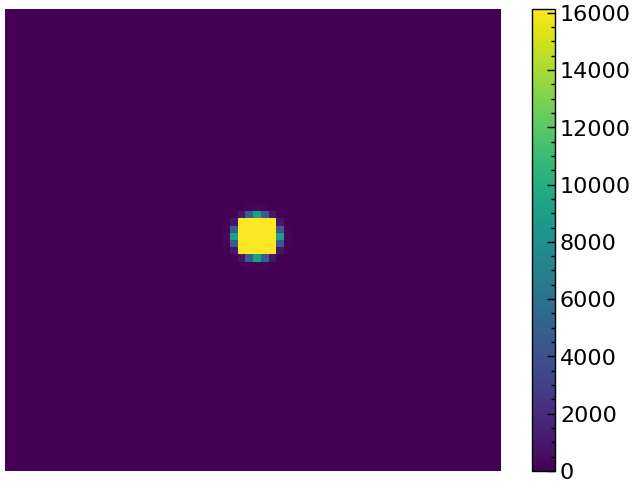

In [22]:
plt.figure(figsize=(8,6))
c=plt.pcolormesh(DFT.X[:,:,Ngrid//2],DFT.Y[:,:,Ngrid//2],DFT.Vext[:,:,Ngrid//2].cpu(), cmap='viridis')
plt.colorbar(c)
plt.axis('off')

## Setting the Initial Condition

In [23]:
DFT.Set_InitialCondition()

In [24]:
DFT.rho.min(),DFT.rho.max()

(tensor(0.), tensor(0.4500))

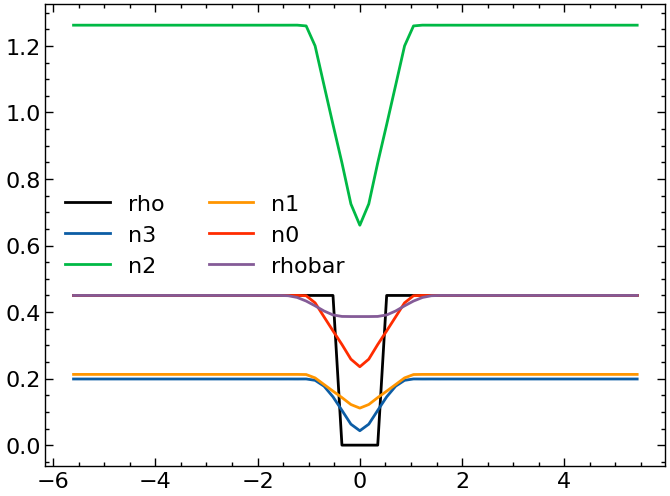

In [25]:
plt.plot(DFT.X[:,Ngrid//2,Ngrid//2],DFT.rho[:,Ngrid//2,Ngrid//2].numpy(),color='k',label='rho')
plt.plot(DFT.X[:,Ngrid//2,Ngrid//2],DFT.n3[:,Ngrid//2,Ngrid//2].cpu().numpy(),label='n3')
plt.plot(DFT.X[:,Ngrid//2,Ngrid//2],DFT.n2[:,Ngrid//2,Ngrid//2].cpu().numpy(),label='n2')
plt.plot(DFT.X[:,Ngrid//2,Ngrid//2],DFT.n1[:,Ngrid//2,Ngrid//2].cpu().numpy(),label='n1')
plt.plot(DFT.X[:,Ngrid//2,Ngrid//2],DFT.n0[:,Ngrid//2,Ngrid//2].cpu().numpy(),label='n0')
plt.plot(DFT.X[:,Ngrid//2,Ngrid//2],DFT.rhobar[:,Ngrid//2,Ngrid//2].cpu().numpy(),label='rhobar')
plt.legend(loc='best',ncols=2)

## Calculate Equilibrium

In [26]:
DFT.Calculate_Equilibrium(alpha0=0.1,dt=0.1,method='fire',logoutput=True)

0 -1282.5704 365532.16 0.1
1 -2474.918 53239.082
2 -2530.239 15604.049
3 -2542.979 8032.8057
4 -2548.2559 4795.8345
5 -2550.5999 2778.7175
6 -2551.7903 1854.468
7 -2552.478 1283.5715
8 -2552.9194 862.9894
9 -2553.2239 577.0533
10 -2553.4456 409.09653
11 -2553.6057 307.31976
12 -2553.7156 236.02219
13 -2553.7815 181.15675
14 -2553.8135 140.7742
15 -2553.8264 110.838394
16 -2553.8445 69.659035
17 -2553.8386 85.38408
18 -2553.839 85.27167
19 -2553.8416 81.891266
20 -2553.8447 76.386826
21 -2553.8496 68.979866
22 -2553.854 59.980465
23 -2553.8584 49.80457
24 -2553.8625 38.990917
25 -2553.8662 28.284027
26 -2553.8674 18.964367
27 -2553.8682 13.79077
28 -2553.8682 15.317535
29 -2553.8677 19.937136
30 -2553.8667 23.698969
31 -2553.8667 24.74346
32 -2553.867 21.631493
33 -2553.869 11.607433
34 -2553.8682 13.765124
35 -2553.8687 13.626571
36 -2553.8682 13.384172
37 -2553.869 13.044688
38 -2553.8684 12.610887
39 -2553.8687 12.088717
40 -2553.8684 11.484815
41 -2553.8687 10.806372
42 -2553.8687 1

In [27]:
DFT.Niter

75

In [28]:
DFT.rho.min(),DFT.rho.max()

(tensor(0.), tensor(0.7312))

In [29]:
DFT.Omega

tensor(-2553.8694)

(-5.6875, 5.512499999999988, -5.6875, 5.512499999999988)

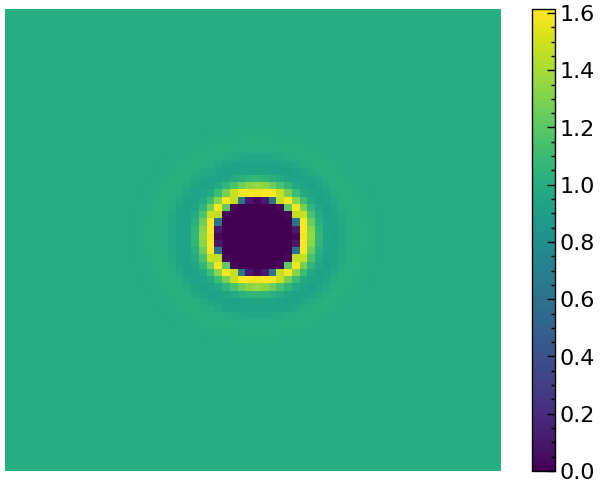

In [30]:
plt.figure(figsize=(8,6))
c=plt.pcolormesh(DFT.X[:,:,Ngrid//2],DFT.Y[:,:,Ngrid//2],DFT.rho[:,:,Ngrid//2].numpy()/rhob, cmap='viridis')
plt.colorbar(c)
plt.axis('off')

In [31]:
# np.save(f'radialdistribution-3D-rhob={rhob}-kT={kT}-Ngrid={Ngrid}-ljmethod={DFT.ljmethod}.npy',(DFT.Z[Ngrid//2,Ngrid//2,:],DFT.rho[Ngrid//2,Ngrid//2,:].numpy()/rhob))

# r,g = np.load(f'radialdistribution-3D-rhob={rhob}-kT={kT}-Ngrid=128-ljmethod={DFT.ljmethod}.npy')

## Plotting g(r)

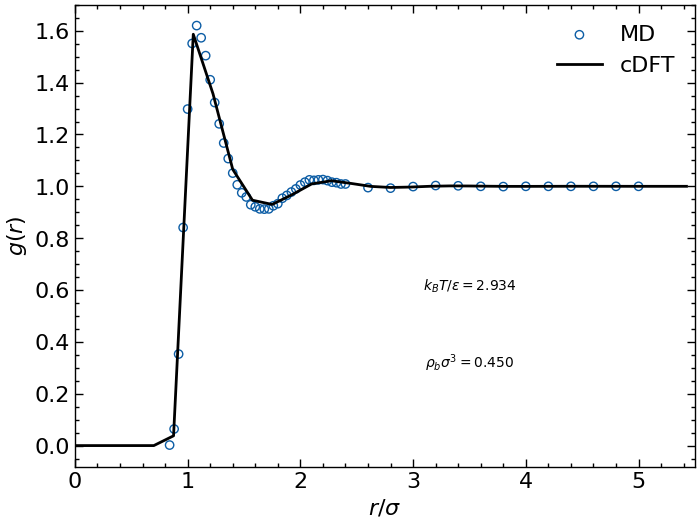

In [32]:
import pandas as pd
df = pd.read_excel('data/MC/MCdata-radialdistribution-lennardjones-Verlet1968.xls',sheet_name='rhob=0.450')
plt.scatter(df['r'],df['KT=2.934'],marker='o',edgecolors='C0',facecolors='none',label='MD')
plt.plot(DFT.Z[Ngrid//2,Ngrid//2,:],DFT.rho[Ngrid//2,Ngrid//2,:].numpy()/rhob,'-',color='k',label=r'cDFT')
plt.xlim(0.0,5.5)
# plt.ylim(0,2.0)
plt.xlabel(r'$r/\sigma$')
plt.ylabel(r'$g(r)$')
plt.text(3.5,0.6,r'$k_B T/\epsilon = 2.934$',ha='center')
plt.text(3.5,0.3,r'$\rho_b \sigma^3 = 0.450$',ha='center')
plt.legend(loc='upper right',ncol=1)